# Python translation to the TDLAS MATLAB code with annotation and validation

# Python translation to the TDLAS MATLAB code with annotation and validation

The script version of code contains individual py files, for function definitions, input definitions and main code.  Here, they are combined in systematic order along with anootations on the equations and methods being used in the code

The variable and function names used in this script are the same as the ones used in MATLAB, the variable names may not be appropriate at some locations.

## Input parameters definition

This section contains the definitions of parameters that are used in the computation

In [26]:
# HITRAN database filename

loc_file = '/home/saumya/Documents/Flame_dianostics-temperature_profile_estimation_using_ML/spec_data/data_new/'

HITRAN_filename       = loc_file + '01_7000-7500_HITEMP2010_7443.2-7445.5.par'

# partition filename
PART_filename         = "q1.txt"

# minimum and maximum wave numbers in cm^-1
nu_1_min              = 7443.9
nu_1_max              = 7445.1

# number of terms between min ans max wave numbers to be considered
N_nu_range            = 3000

# total radial distance in cm and radial step size
total_radial_distance = 55
freq = 1000
delta_x               = 55/freq

# parameters for temperature and mole fraction fields construction-------------
# maximum flame temperature and ambient temperature
T_mag_uni_field       = A1 = 950.0
A2                    = 300.0

# location where flame temperature reaches half the maximum temperature
X0                    = 6.0*total_radial_distance/7.0

# gradient of the transition region
A3                    = 0.06

# maximum and ambient mole fraction of water vapour
x_mag_uni_field       = B1 = 0.095
B2                    = 0.028

Following are the constants used in the work

In [27]:
# reference temperature
T0 = 296.0

# Plank's constant
h  = 6.62607004e-34

# speed of light in cm/s in vacuum
c  = 29979245800

# Boltzmann constant
k  = 1.38064852e-23

# molar mass of water
M  = 18.01

P  = 1 #  <----------- DOUBT   /unit =  ATM

# Avogadro number
Na = 6.02214076e23

___

## Importing libraries/modules 

The needed modules and libraries are imported in this section

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import wofz     # Voigt function



from multiprocessing import Pool
from tqdm import *

___

## Function definitions

### HITRAN database reader function

This function was developed to read the Hi-resolution Tranmission database file for the chosen species of H2O.
This will return the pandas dataframe with all the columns 

In [29]:
def HITRAN_reader(fname):

    # reading all file contents
    fid = open(fname,"r")
    lines = fid.readlines()

    # preparing lists to store line values
    molNo_list = []; isoNo_list = []; transitionWaveNo_list = []
    lineIntensity_list = []; einsteinACoeff_list = []; airBroadenedWidth_list = []
    selfBroadenedWidth_list = []; lowEState_list = []; tempCoeff_list = []
    pressureShift_list = []; upperVibQuanta_list = []; lowerVibQuanta_list = []
    upperLocalQuanta_list = []; lowerLocalQuanta_list = []; errorCodes_list = []
    referenceCodes_list = []; flagLineMixing_list = []
    upperStatisticalWeight_list = []; lowerStatisticalWeight_list = []


    # looping through the lines to read individual data
    for line in lines:
        # setting starting read position on the string
        idx = 0

        # reading molecule number
        molNo = int(float(line[idx:idx+2]))
        idx+=2

        # isotopologue number
        isoNo = int(float(line[idx:idx+1]))
        idx+=1

        # transition wavenumber / vaccum wavenumber
        transitionWaveNo = float(line[idx:idx+12])
        idx+=12

        # line intensity
        lineIntensity = float(line[idx:idx+10])
        idx+=10

        # einstein A-coefficient
        einsteinACoeff = float(line[idx:idx+10])
        idx+=10

        # air-broadened half width / air-broadened width
        airBroadenedWidth = float(line[idx:idx+5])
        idx+=5

        # self-broadened half width / self-broadened width
        selfBroadenedWidth = float(line[idx:idx+5])
        idx+=5

        # lower energy state
        lowEState = float(line[idx:idx+10])
        idx+=10

        # temperature dependence coefficient
        tempCoeff = float(line[idx:idx+4])
        idx+=4

        # pressure shift / air-pressure-induced line shift
        pressureShift = float(line[idx:idx+8])
        idx+=8

        # upper vibrational quanta / upper-state "global" quanta
        upperVibQuanta = line[idx:idx+15]
        idx+=15

        # lower vibrational quanta / lower-state "global" quanta
        lowerVibQuanta = line[idx:idx+15]
        idx+=15

        # upper local quanta / upper-state "local" quanta
        upperLocalQuanta = line[idx:idx+15]
        idx+=15

        # lower local quanta / lower-state "local" quanta
        lowerLocalQuanta = line[idx:idx+15]
        idx+=15

        # error codes / uncertainity indices
        errorCodes = line[idx:idx+6]
        idx+=6

        # reference codes / reference indices
        referenceCodes = line[idx:idx+12]
        idx+=12

        # flag for lineMixing / Flag
        flagLineMixing = line[idx:idx+1]
        idx+=1

        # upper statistical weight / statistical weight for the upper state
        upperStatisticalWeight = float(line[idx:idx+7])
        idx+=7

        # lower statistical weight / statistical weight for the lower state
        lowerStatisticalWeight = float(line[idx:idx+7])
        idx+=7

        # appending read values to the lists
        molNo_list.append(molNo)
        isoNo_list.append(isoNo)
        transitionWaveNo_list.append(transitionWaveNo)
        lineIntensity_list.append(lineIntensity)
        einsteinACoeff_list.append(einsteinACoeff)
        airBroadenedWidth_list.append(airBroadenedWidth)
        selfBroadenedWidth_list.append(selfBroadenedWidth)
        lowEState_list.append(lowEState)
        tempCoeff_list.append(tempCoeff)
        pressureShift_list.append(pressureShift)
        upperVibQuanta_list.append(upperVibQuanta)
        lowerVibQuanta_list.append(lowerVibQuanta)
        upperLocalQuanta_list.append(upperLocalQuanta)
        lowerLocalQuanta_list.append(lowerLocalQuanta)
        errorCodes_list.append(errorCodes)
        referenceCodes_list.append(referenceCodes)
        flagLineMixing_list.append(flagLineMixing)
        upperStatisticalWeight_list.append(upperStatisticalWeight)
        lowerStatisticalWeight_list.append(lowerStatisticalWeight)

        #  break

    # column names for pandas dataframe
    colNames = ["moleculeNumber","isotopologueNumber","transisionWaveNumber",
                "lineIntensity","einsteinACoefficient","airBroadenedWidth",
                "selfBroadenedWidth","lowerStateEnergy","temperatureDependence",
                "pressureShift","upperVibrationalQuanta","lowerVibrationalQuanta",
                "upperLocalQuanta","lowerLocalQuanta","errorCodes",
                "referenceCodes","flagForLineMixing","upperStatisticalWeight",
                "lowerStatisticalWeight"]

    # preparing dataframe
    fid = pd.DataFrame(np.transpose([molNo_list,isoNo_list,transitionWaveNo_list,
                                     lineIntensity_list,einsteinACoeff_list,
                                     airBroadenedWidth_list,selfBroadenedWidth_list,
                                     lowEState_list,tempCoeff_list,pressureShift_list,
                                     upperVibQuanta_list,lowerVibQuanta_list,
                                     upperLocalQuanta_list,lowerLocalQuanta_list,
                                     errorCodes_list,referenceCodes_list,flagLineMixing_list,
                                     upperStatisticalWeight_list,lowerStatisticalWeight_list]),
                       columns = colNames)

    # writing dataframe to csv file
    fid.to_csv("HITEMP_data.csv", index = None)

    # returning dataframe
    return fid

### Partition function interpolator

This function interpolates the partition function values over a range of temperatures and obtains the interpolated value for the given temperature

In [30]:
def Q_func(T, T_series, Q_series):
    """
    This function obtains the value of partition function for given temperature
    through linear interpolation

    T        - given input temperature
    T_series - series of temperature values from database
    Q_series - series of partition function values corresponding to each
               temperature in the database
    """

    return np.interp(T,T_series,Q_series)

### Line strength function

This function computes the line strength using the following equation 
$$ S(T) = S(T_0) \frac{Q(T_0)}{Q(T)}\frac{T_0}{T} exp\left(\frac{-h c E"}{k}\left(\frac{1}{T}-\frac{1}{T_0}\right)\right)\frac{\left[1 - exp\left(\frac{-h c \nu_0}{k T}\right)\right]}{\left[1 - exp\left(\frac{-h c \nu_0}{k T_0}\right)\right]}$$

In [31]:
def lineStrength(S0, nu0, Edd, T, fid_Q):
    """
    This function computes the line strength of a particular transition
    at a given temperature

    equation has been split into 4 parts for ease of programming
    """

    part_1 = Q_func(T0,fid_Q["T"],fid_Q["Q"])/Q_func(T,fid_Q["T"],fid_Q["Q"])
    part_2 = T0/T*np.exp(-h*c/k*Edd*(1/T - 1/T0))
    part_3 = 1 - np.exp(-h*c*nu0/k/T)
    part_4 = 1 - np.exp(-h*c*nu0/k/T0)

    S = S0*part_1*part_2*part_3/part_4

    return S

### Spectral absorption coefficient function

This function computes the spectral absorption coefficient for a given x over all the wave numbers

Here, 
the $a$  equation is given below, it describes the gausian half-width at half maximum value
$$ a = 2 \sqrt{log(2)} \frac{\nu - \nu_0}{\alpha_G} $$

the $w$ equation which describes the lorenztian half-width at half maximum is given below
$$ w = \sqrt{log(2)} \frac{\alpha_L}{\alpha_G} $$

Then the $\phi$ function value is computed with the equation described below
$$ \phi(\nu) = \frac{2}{\alpha_G}\sqrt{\frac{log(2)}{\pi}}V(z) \; \; \; \forall \; \; \; z = a + w i $$

Finally, the value of spectral absorption coefficient is computed by the dot product of (line intensity, mole fraction and presure) and the $\phi$ function as given below
$$ K(x) = \left(S(T) \times \chi \times P\right) . \phi(\nu,T) $$

The name of the function is given as per the MATLAB code, 


In [32]:
def voigt(dat, nu0, s, delnu_g, delnu_l):
    """
    this function computes value of K (spectral absorption coefficient)
    at given X location for all wave numbers.

    The name of this program function is given  as per the matlab code
    """

    # computing difference between chosen wavenumber ranges and wave number
    # from the HITRAN database
    """ for this, the matrix is obtained by subtracting each element of one
    arrau over each other elements of the other array"""
    vv0 = nu0 - dat.reshape(dat.shape[0],1) #  it is (nu-nu0) in the equation

    # computing "a" equation from problem definition
    """
    DOUBT:
    here a 2 is missing in the code but present in the pblm definition
    """
    a = np.sqrt(np.log(2))*vv0/delnu_g

    # computing "w" equation from problem definition
    w = np.sqrt(np.log(2))*np.ones([dat.shape[0],1])*delnu_l/delnu_g

    # combining w and a into a complex function to feed it to voigt function
    z = a+w*1j

    # computing phi function
    """
    DOUBT:
    here a 2 is missing in the code but present in the pblm definition
    """
    phi = 1/delnu_g*np.sqrt(np.log(2)/np.pi)*wofz(z)

    # computing the K function in problem definition for current X value
    K = np.matmul(np.real(phi),s)

    return K


___

## Computing the Non-uniform Absorption Spectra

Reading the HITRAN database and the partition function table

In [33]:
# reading data from HITRAN file
fid_HITRAN = HITRAN_reader(HITRAN_filename)

# reading Partition function table
fid_Q = pd.read_csv(PART_filename, header = None, delim_whitespace = True,
                    names = ["T","Q"])

/tmp/ipykernel_6172/3202423560.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fid_Q = pd.read_csv(PART_filename, header = None, delim_whitespace = True,


Extracting individual columns of data from the database and computing a range of wave numbers between the given min and max ranges

In [34]:
# reading data from the database file
# center wavenumber
nu0  = fid_HITRAN["transisionWaveNumber"].to_numpy().astype("float64")
# reference line strength
s0   = fid_HITRAN["lineIntensity"].to_numpy().astype("float64")
# air-broadened width
g_a0 = fid_HITRAN["airBroadenedWidth"].to_numpy().astype("float64")
# self-broadened width
g_s0 = fid_HITRAN["selfBroadenedWidth"].to_numpy().astype("float64")
# lower state energy
Edd0 = fid_HITRAN["lowerStateEnergy"].to_numpy().astype("float64")
# temperature dependence exponent
n    = fid_HITRAN["temperatureDependence"].to_numpy().astype("float64")
# pressure shift coefficient
d0   = fid_HITRAN["pressureShift"].to_numpy().astype("float64")

# computing a range of wave numbers
dat1 = np.linspace(nu_1_min, nu_1_max, N_nu_range)

Filtering the entries from database based on the following criteria
- line intensity should be greater than $10^{-30}$
- dropping extreme wave numbers 

In [35]:
# selecting the indices of entries with nu0 falling b/w extreme nu values and
# with line intensity <= 10^-30
index1 = (nu0 > nu_1_min) & (nu0 < nu_1_max)
index2 = s0 > 1e-35
index  = index1 & index2

nu1   = nu0[index]
s01   = s0[index]
g_a01 = g_a0[index]
g_s01 = g_s0[index]
Edd1  = Edd0[index]
n1    = n[index]
d01   = d0[index]

pressure is taken to be contstant, hence, multiplying the line strength with pressure and some conversion factor

In [36]:
S0 = s01*2.479371939e19*P #  <-------------- DOUBT       UNIT CONVERSION

In [37]:
def repeat(arr, count):
    return np.ravel(np.stack([arr for _ in range(count)], axis=0))

In [38]:
def run_apply_async_multiprocessing(func, argument_list, num_processes):

    pool = Pool(processes=num_processes)

    jobs = [pool.apply_async(func=func, args=(*argument,)) if isinstance(argument, tuple) else pool.apply_async(func=func, args=(argument,)) for argument in argument_list]
    pool.close()
    result_list_tqdm = []
    for job in tqdm(jobs):
        result_list_tqdm.append(job.get())

    return result_list_tqdm

Constructing the temperature and mole fraction profiles along with discretizing the x-locations

In [39]:
def calc_abs(loc, xor=0.1, *args, **kwargs):
    # temperature and mole fraction fields construction----------------------------

    # loc_pro = loc
    # name = 'Temp_profile.npy'

    # Temp_pofiles = np.load(loc_pro + name)

    # discretized radial distance
    X = np.arange(0,total_radial_distance+delta_x,delta_x)

    # non uniform temperature field
    # Tnon = A2+(A1-A2)/(1+np.exp((X-X0)/A3))

    Tnon = loc*np.ones((freq))

    # Tnon = Temp_pofiles[100]

    # non uniform mole fraction field
    # xnon = B2+(B1-B2)/(1+np.exp((X-X0)/A3))

    xnon = np.ones((freq))*xor


    # obtaining the size of s0 and Tnon for 2D array pre-allocations
    ns = S0.shape[0]
    nt = Tnon.shape[0] - 1 #  <----------------- DOUBT, nt+1 is actually nx,,    it is due to section of absorbance... 

    # preallocating 2d arrays
    s       = np.zeros([nt,ns]) # line strength
    d       = np.zeros([nt,ns]) # pressure shift coefficient
    g_a     = np.zeros([nt,ns]) # air broadened width
    g_s     = np.zeros([nt,ns]) # self broadened width
    nu0_s   = np.zeros([nt,ns]) # shifted center-wavenumber
    delnu_g = np.zeros([nt,ns]) # gaussian half-width at halft maximum
    delnu_l = np.zeros([nt,ns]) # lorentzian half-width at halft maximum

    # computing spatial step size
    dx = np.diff(X)


    # looping through all x-locations and given line intensities
    for i in range(ns):
        for j in range(nt):
            # getting current mole fractionp.shape(Abs).shapen value
            x = xnon[j]

            # computing the pressure shift coefficient
            d[j,i] = d01[i]*(T0/Tnon[j])**0.96

            # air broadened width
            g_a[j,i] = g_a01[i]*(T0/Tnon[j])**n1[i]

            # self broadened width
            g_s[j,i] = g_s01[i]*(T0/Tnon[j])**0.75

            # shifted center wave nuber
            nu0_s[j,i] = nu1[i] + P*(1-x)*d[j,i]

            # line strength
            s[j,i] = lineStrength(S0[i], nu0_s[j,i], Edd1[i], Tnon[j], fid_Q)*dx[j]*x

            # gaussian HWHM
            delnu_g[j,i] = np.sqrt(2*k*np.log(2)*Na/c**2*1000*10**4)*nu0_s[j,i]*np.sqrt(Tnon[j]/M)
            # delnu_g[j,i] = 0.5*7.162242257e-7*nu0_s[j,i]*np.sqrt(Tnon[j]/M)

            # lorentian HWHM
            delnu_l[j,i] = P*(x*g_s[j,i]+(1-x)*g_a[j,i])



    # pre-allocating absorbance array for all wave numbers
    """
    it is -ln(I(nu)/I_0)
    """
    Absorbance = np.zeros([N_nu_range])

    # computing absorbance coef
    # ficient K for each x and suming it up for total
    for i in range(X.shape[0]-2): #  <-------------- DOUBT
        Absorbance += voigt(dat1, nu0_s[i,:], s[i,:], delnu_g[i,:], delnu_l[i,:])

    return Absorbance.astype(np.half)*2

In [40]:
# tp = np.load('/home/saumya/Documents/Flame_dianostics-temperature_profile_estimation_using_ML/FINAL_VISUAL/DOWN_temp.npy')

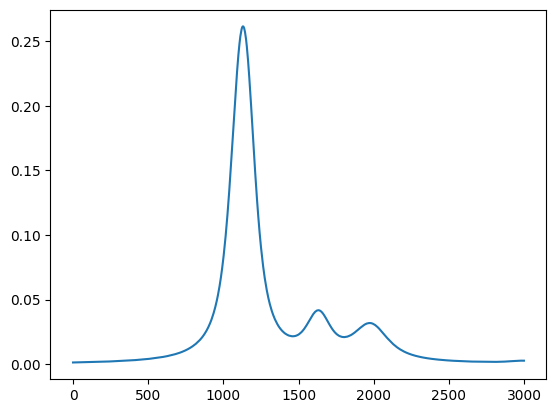

In [43]:
plt.plot(calc_abs(400+273, 0.026)/2)

In [44]:
max(calc_abs(400+273, 0.026)/2)

0.2615

In [45]:
b

NameError: name 'b' is not defined

In [ ]:
kwel = calc_abs(tp+273, 0.026)

In [ ]:
max()

0.3508

In [ ]:
np.savetxt("absorb", kwel)

In [ ]:
np.savetxt('xaxis', dat1)

In [ ]:
pro_loc = '/home/saumya/Documents/Flame_dianostics-temperature_profile_estimation_using_ML/Spectra_gen/Profile/profile_SNR.npy'

profile = np.load(pro_loc)
profile = profile[:10]

data_ph = [ i for i in profile]

In [ ]:
# temp_pro = np.linspace(1500, 2200, 1000)

# temp_pro = np.repeat(temp_pro, 10)

# xor_pro = np.linspace(0.1, 0.3, 10)

# xor_pro = repeat(xor_pro, 1000) 

# data_ph = [ i for i in zip(temp_pro, xor_pro)] 
# data_ph = argument_list = [(random.randint(1500, 2200), random.randint(1, 3)/ 10) for _ in range(num_jobs)]

In [ ]:
print("Running apply_async multiprocessing for multi-argument functions ...")


Abs = run_apply_async_multiprocessing(func=calc_abs, argument_list=data_ph, num_processes=12)
# assert result_list == data_ph

Running apply_async multiprocessing for multi-argument functions ...


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


In [ ]:
# for i in xor_pro:
#     np.append(Abs, imap_unordered_bar(calc_abs, [temp_pro, xor_pro]))

In [ ]:
absorption = calc_abs(profile[0])

In [ ]:
# Tnon = np.ones_like(Tnon)*Tnon.max()

# xnon = np.ones_like(xnon)*xnon.max()

Creating 2D matrices with size being the number of line strength entities and the number of x-locations,
and computing the spatial step size

In [ ]:
# # obtaining the size of s0 and Tnon for 2D array pre-allocations
# ns = S0.shape[0]
# nt = Tnon.shape[0] - 1 #  <----------------- DOUBT, nt+1 is actually nx,,    it is due to section of absorbance... 

# # preallocating 2d arrays
# s       = np.zeros([nt,ns]) # line strength
# d       = np.zeros([nt,ns]) # pressure shift coefficient
# g_a     = np.zeros([nt,ns]) # air broadened width
# g_s     = np.zeros([nt,ns]) # self broadened width
# nu0_s   = np.zeros([nt,ns]) # shifted center-wavenumber
# delnu_g = np.zeros([nt,ns]) # gaussian half-width at halft maximum
# delnu_l = np.zeros([nt,ns]) # lorentzian half-width at halft maximum

# # computing spatial step size
# dx = np.diff(X)

Looping through all the filtered database entries and the x-locations and computing the following 
- Pressure shift coefficient
$$ \delta_{p} = \delta_0 \left(\frac{T_0}{T}\right)^{0.96} $$
- Air broadened width
$$ \gamma_{air}(T) = \gamma_{air}(T_0)\left(\frac{T_0}{T}\right)^{n_{air}} $$
- Self broadened width
$$ \gamma_{self}(T) = \gamma_{self}(T_0) \left(\frac{T_0}{T}\right)^{0.75} $$
- Shifted center wave number
$$ \nu_0 = \nu + P (1-\chi) \delta_{p} $$
- Line strength with product of mole fraction and spatial step size
$$ S(T) = S(T_0) \frac{Q(T_0)}{Q(T)}\frac{T_0}{T} exp\left(\frac{-h c E"}{k}\left(\frac{1}{T}-\frac{1}{T_0}\right)\right)\frac{\left[1 - exp\left(\frac{-h c \nu_0}{k T}\right)\right]}{\left[1 - exp\left(\frac{-h c \nu_0}{k T_0}\right)\right]}$$
$$ S(T) \chi dx $$
- Gaussian half width at half maximum (1000 is a unit conversion factor for $N_a$ and $10^4$ for $c$ in cm/s)
$$ \alpha_G = \nu_0\left(\frac{2 N_a k T log(2) \times 1000 \times 10^4}{m c^2}\right)^{\frac{1}{2}} $$
- Lorentzian half width at half maximum 
$$ \alpha_L = P \left(\chi \gamma_{self} + (1 - \chi) \gamma_{air}\right) $$

In [ ]:
# # looping through all x-locations and given line intensities
# for i in range(ns):
#     for j in range(nt):
#         # getting current mole fraction value
#         x = xnon[j]

#         # computing the pressure shift coefficient
#         d[j,i] = d01[i]*(T0/Tnon[j])**0.96

#         # air broadened width
#         g_a[j,i] = g_a01[i]*(T0/Tnon[j])**n1[i]

#         # self broadened width
#         g_s[j,i] = g_s01[i]*(T0/Tnon[j])**0.75

#         # shifted center wave nuber
#         nu0_s[j,i] = nu1[i] + P*(1-x)*d[j,i]

#         # line strength
#         s[j,i] = lineStrength(S0[i], nu0_s[j,i], Edd1[i], Tnon[j], fid_Q)*dx[j]*x

#         # gaussian HWHM
#         delnu_g[j,i] = np.sqrt(2*k*np.log(2)*Na/c**2*1000*10**4)*nu0_s[j,i]*np.sqrt(Tnon[j]/M)
#         # delnu_g[j,i] = 0.5*7.162242257e-7*nu0_s[j,i]*np.sqrt(Tnon[j]/M)

#         # lorentian HWHM
#         delnu_l[j,i] = P*(x*g_s[j,i]+(1-x)*g_a[j,i])

Computing the absorption spectra
$$ K(x) = P \chi(x) \sum_{i = 1}^{N_x} S(T_i) \phi(\nu_i,T_i) $$

In [ ]:
# # pre-allocating absorbance array for all wave numbers
# """
# it is -ln(I(nu)/I_0)
# """
# Absorbance = np.zeros([N_nu_range])

# # computing absorbance coefficient K for each x and suming it up for total
# for i in range(X.shape[0]-2): #  <-------------- DOUBT
#     Absorbance += voigt(dat1, nu0_s[i,:], s[i,:], delnu_g[i,:], delnu_l[i,:])

___

## Post-processing 

Preparing pandas dataframe with computed values, and compute error percentage with MATLAB output, then write computed values to a csv file

In [ ]:
# # reading matlab output file
# fid_mat = pd.read_csv("absorbance_matlab.csv", header = None,
#                       names = ["wavenumber", "absorbance"])

# # writing computed values to file along with matlab
# fid_ab = pd.DataFrame(np.transpose([dat1, Absorbance]), columns = ["wavenumber",
#                                                             "absorbance"])
# fid_ab["absorbance_matlab"] = fid_mat["absorbance"]
# fid_ab["error_percentage"] = abs((fid_ab["absorbance_matlab"]-fid_ab["absorbance"])/fid_ab["absorbance_matlab"])*100.0
# fid_ab.to_csv("absorbance_pythonOutput.csv", index = None)

Plotting comparison and error graphs

In [ ]:
# # plotting absorbance graph
# plt.figure()
# plt.plot(dat1, absorption, '-b', label = "Python")
# # plt.plot(fid_mat["wavenumber"], fid_mat["absorbance"], '-r', label = "MATLAB")
# plt.grid()
# plt.legend()
# plt.xlabel("wave numbers")
# plt.ylabel("Absorbance")
# plt.title("Absorbance comparison")
# plt.savefig("absorbance.png", dpi = 150)

# # # plotting error percentage between matlab and python
# # plt.figure()
# # plt.plot(fid_ab["wavenumber"],fid_ab["error_percentage"], '-b')
# # plt.grid()
# # plt.xlabel("wave number")
# # plt.ylabel("error percentage")
# # plt.title("Error percentage w.r.t. matlab output")
# # plt.savefig("error.png", dpi = 150)

# # plt.show()


In [ ]:
# # plotting absorbance graph
# plt.figure()
# plt.plot(dat1, Abs[9], '-b', label = "Python")
# # plt.plot(fid_mat["wavenumber"], fid_mat["absorbance"], '-r', label = "MATLAB")
# plt.grid()
# plt.legend()
# plt.xlabel("wave numbers")
# plt.ylabel("Absorbance")
# plt.title("Absorbance comparison")
# plt.savefig("absorbance.png", dpi = 150)

In [ ]:
import os


os.chdir('/home/saumya/Documents/Spec_data/Temp_uniform_Mol_uniform/')

In [ ]:
np.save('abs_SNR_clean', Abs)

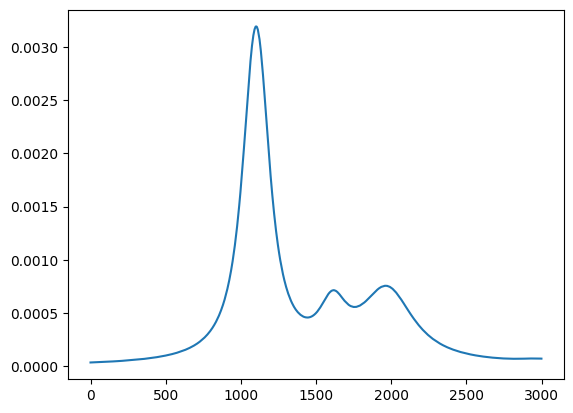

In [ ]:
plt.plot(Abs[1])

In [ ]:
def signalPower(x):
    return np.average(x**2)

In [ ]:
def SNR(signal, noise):
    powS = signalPower(signal)
    powN = signalPower(noise)
    return 10*np.log10((powS-powN)/powN)

In [ ]:
def add_adgn(sig, SNR):
    # Set a target SNR
    x_volts = sig
    x_watts = x_volts ** 2
    x_db = 10 * np.log10(x_watts)
    target_snr_db = SNR
    # Calculate signal power and convert to dB 
    sig_avg_watts = np.mean(x_watts)
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    # Generate an sample of white noise
    mean_noise = 0
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
    # Noise up the original signal
    y_volts = x_volts + noise_volts
    return y_volts

In [ ]:
SNR = 33.5505

In [ ]:
u = []
for i in Abs:
    y = add_adgn(i, SNR)
    u.append(y)

u = np.array(u)

/tmp/ipykernel_77934/3268249564.py:5: RuntimeWarning: divide by zero encountered in log10
  x_db = 10 * np.log10(x_watts)


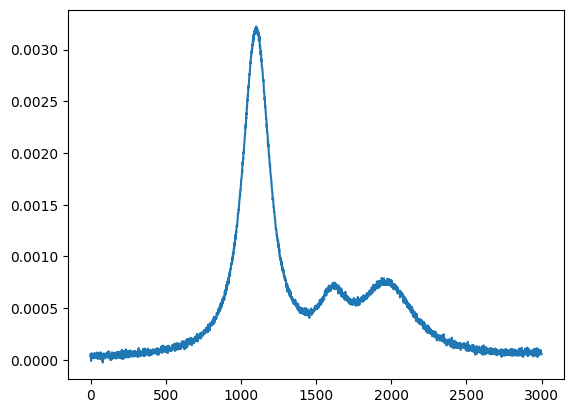

In [ ]:
plt.plot(u[0])

In [ ]:
np.save('ABS_noisy_SNR', u)